Regresión Logistica 

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np 
import os
from matplotlib import style
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.weightstats import ttest_ind

In [13]:
data = pd.read_csv("C:/datacc/framingham.csv", sep=",")

In [14]:
data.dropna(inplace=True)
data.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [15]:
datab = data[["TenYearCHD", "totChol"]]
datab.head()

,TenYearCHD,totChol
0,0,195.0
1,0,250.0
2,0,245.0
3,1,225.0
4,0,285.0


In [16]:
datab.TenYearCHD.value_counts().sort_index()

0    3099
1     557
Name: TenYearCHD, dtype: int64

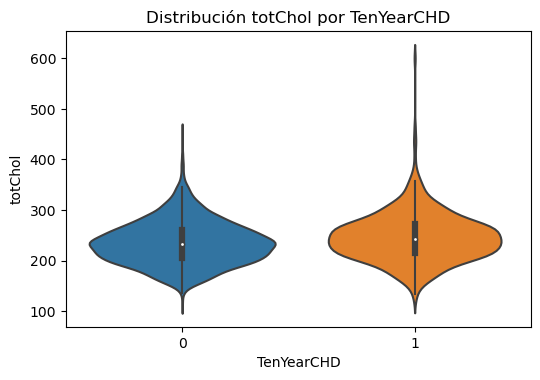

In [18]:
fig, ax = plt.subplots(figsize=(6, 3.84))

sns.violinplot(
        x     = 'TenYearCHD',
        y     = 'totChol',
        data  = datab,
        ax    = ax
    )

ax.set_title('Distribución totChol por TenYearCHD');

In [21]:
res_ttest = ttest_ind(
                x1 = datab.loc[datab["TenYearCHD"]==0, "totChol"],
                x2 = datab.loc[datab["TenYearCHD"]==1, "totChol"],
                alternative='two-sided'
            )
print(f"t={res_ttest[0]}, p-value={res_ttest[1]}")

t=-5.531474439833636, p-value=3.398308583622179e-08


In [24]:
X = datab[['totChol']]
y = datab['TenYearCHD']

X_train, X_test, y_train, y_test = train_test_split(
                                        X.values.reshape(-1,1),
                                        y.values.reshape(-1,1),
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
)
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.Logit(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

Optimization terminated successfully.
         Current function value: 0.434258
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 2924
Model:                          Logit   Df Residuals:                     2922
Method:                           MLE   Df Model:                            1
Date:                Sun, 24 Sep 2023   Pseudo R-squ.:                 0.01251
Time:                        03:37:49   Log-Likelihood:                -1269.8
converged:                       True   LL-Null:                       -1285.9
Covariance Type:            nonrobust   LLR p-value:                 1.407e-08
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.1747      0.275    -11.540      0.000      -3.714      -2.636
x1             0.0063      0.

In [25]:
predicciones = modelo.predict(exog = X_train)

clasificacion = np.where(predicciones<0.5, 0, 1)
clasificacion

array([0, 0, 0, ..., 0, 0, 0])

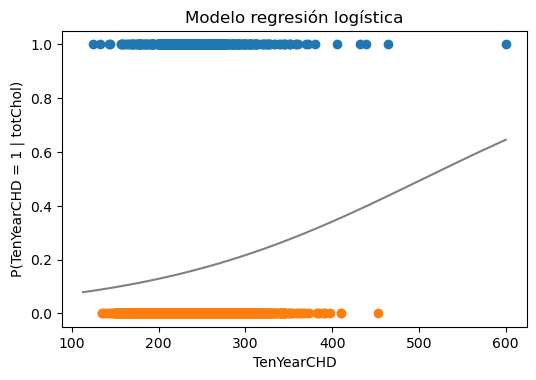

In [27]:
grid_X = np.linspace(
            start = min(datab.totChol),
            stop  = max(datab.totChol),
            num   = 200
         ).reshape(-1,1)

grid_X = sm.add_constant(grid_X, prepend=True)
predicciones = modelo.predict(exog = grid_X)
fig, ax = plt.subplots(figsize=(6, 3.84))

ax.scatter(
    X_train[(y_train == 1).flatten(), 1],
    y_train[(y_train == 1).flatten()].flatten()
)
ax.scatter(
    X_train[(y_train == 0).flatten(), 1],
    y_train[(y_train == 0).flatten()].flatten()
)
ax.plot(grid_X[:, 1], predicciones, color = "gray")
ax.set_title("Modelo regresión logística")
ax.set_ylabel("P(TenYearCHD = 1 | totChol)")
ax.set_xlabel("TenYearCHD");

In [28]:
X_test = sm.add_constant(X_test, prepend=True)
predicciones = modelo.predict(exog = X_test)
clasificacion = np.where(predicciones<0.5, 0, 1)
accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = clasificacion,
            normalize = True
           )
print("")
print(f"El accuracy de test es: {100*accuracy}%")


El accuracy de test es: 87.8415300546448%


In [29]:
confusion_matrix = pd.crosstab(
    y_test.ravel(),
    clasificacion,
    rownames=['Real'],
    colnames=['Predicción']
)
confusion_matrix

Predicción,0
Real,
0,643
1,89


El modelo de regresión logística muestra una relación entre la variable independiente "totChol" y la variable objetivo "TenYearCHD". Sin embargo, la capacidad predictiva del modelo es limitada, ya que el Pseudo R-squared es bajo, lo que indica que hay otras variables no incluidas en el modelo que también pueden influir en la probabilidad de desarrollar enfermedad cardíaca en 10 años (TenYearCHD).

La precisión del modelo en el conjunto de prueba es del 87.84%, lo que sugiere que el modelo tiene cierta capacidad para predecir la ocurrencia de TenYearCHD, pero también hay falsos negativos, lo que indica que hay casos que el modelo no puede predecir correctamente.

En resumen, el modelo de regresión logística proporciona información sobre cómo totChol está relacionado con la probabilidad de desarrollar enfermedad cardíaca en 10 años, pero su capacidad predictiva es limitada y puede beneficiarse de la inclusión de otras variables relevantes en el modelo. Además, es importante considerar otras métricas de evaluación y realizar un análisis más completo antes de tomar decisiones clínicas o de investigación basadas en este modelo.